# Recurrent Neural Networks
_Sentiment analysis through Recurrent Neural Networks_

---

In this tutorial, we are interested in the problem of sentiment analysis. In the first part, we will build a recurrent network on a toy dataset from scratch to determine if a sentence is positive or negative. In a second step, using the [`Keras`](https://keras.io/) API, we will build a network able to determine if a movie review is positive or negative.

---

In [1]:
import numpy as np
import pandas as pd
import numpy.random as rd
import matplotlib.pyplot as plt
import random

---
# PART I: RNN from Scratch

In order to understand recurrent networks in more detail, our first example will be implementing a network from scratch. The network will perform a (simple) sentiment analysis task, namely determining whether a given text string is positive or negative.


## Pre-Processing

The commands below allow displaying some samples of our toy dataset.

In [5]:
from data import train_data, test_data

list(train_data.items())[:15]

KeyError: 0

### Data Visualization

In order to visualize quickly the labels, we want display in _green_ the <span style="color:green">positive sentences</span>, and in _red_ the <span style="color:orangered">negative sentences</span>.

In [3]:
from colorama import Fore

##### <span style="color:purple">**Todo:** Using the command `Fore.COLOR` of the package [`colorama`](https://pypi.org/project/colorama/), realize such a function.</span>


In [8]:
from colorama import Fore

def coloredSentences(sentences, out=15):
    """
    Display in green the positive sentences, and in red the negative sentences
    - sentences is a dict
        - sentences.keys() are the sentences to display
        - sentences.values() are booleans that encode the sentiment
    - out is an integer indicating the maximum number of sentences to display
    """
    n = min(len(sentences),15)
    for key,value in list(sentences.items())[:n]:
        if value:
            print(Fore.GREEN + key)
        else:
            print(Fore.RED + key)

In [ ]:
# %load solutions/scratch/coloredSentences.py

In [9]:
coloredSentences(train_data)

good
bad
happy
sad
not good
not bad
not happy
not sad
very good
very bad
very happy
very sad
i am happy
this is good
i am bad


### Vocabulary

The datasets consists of two $\texttt{dictionaries}$. Before trying to classify these sentences, we will build a vocabulary of all of all words that exist in our data

##### <span style="color:purple">**Question:** How many different words are in our vocabulary?</span>

To answer this question, start by building a **vocabulary**, _i.e._ a $\texttt{list}$ containing all the words used in the dataset. _Each word should occur only once_.

<!-- 18 unique words found -->

In [18]:
### TO BE COMPLETED ### 
string_all = " ".join(train_data.keys())
vocab = list(set(string_all.split()))
vocab_size = len(vocab)

print('%d unique words found' % vocab_size)
print(vocab)

18 unique words found
['all', 'not', 'earlier', 'and', 'at', 'bad', 'was', 'or', 'very', 'happy', 'i', 'this', 'good', 'am', 'sad', 'right', 'now', 'is']


In [16]:
# %load solutions/scratch/vocab_size.py

### Word Encoding

A neural network cannot take strings as input. So we have to encode these sentences in a format understandable by a computer.

##### <span style="color:purple">**Todo:** Assign an integer index to represent each word of the vocab</span>

To do that, construct two $\texttt{dictionaries}$ allowing to translate words into integer indices, and vice versa :

* $\texttt{word_to_idx}$ has for keys the words of the vocabulary; and for value an integer index, the order in which the words appear in the vocabulary for example.
* $\texttt{word_to_idx}$ performs the opposite translation: its keys are the integer indices while its values are the associated words.

In [17]:
### TO BE COMPLETED ### 

word_to_idx = {vocab[i]:i for i in range(vocab_size)}
idx_to_word = {i:vocab[i] for i in range(vocab_size)}

print(word_to_idx['good'])
print(idx_to_word[0])

12
all


In [ ]:
# %load solutions/scratch/decode.py

This way of encoding words works quite well. However, it has the disadvantage of introducing a preferential but meaningless order in how words are processed. Since the vocabulary size is reasonable, we will use a one-shot encoding instead.

##### <span style="color:purple">**Todo:** Write a function $\texttt{createInputs}$ that performs one-hot encoding</span>

This function will return a $\texttt{list}$ of the one-hot encodings of each word that compose the input sentence.

In [19]:
### TO BE COMPLETED ### 

def createInputs(text):
    '''
    Returns an array of one-hot vectors representing the words in the input text string.
    - text is a string
    - Each one-hot vector has shape (vocab_size, 1)
    '''
    words = text.split()
    out = np.zeros((len(words),vocab_size))
    for i,w in enumerate(words):
        out[i,word_to_idx[w]] = 1
    return out

In [ ]:
# %load solutions/scratch/createInputs.py

In [22]:
print(createInputs('i am very good'))

10
13
8
12
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


## The Forward Phase

In this part, we will build the simplest possible recursive network. To do so, we will create an $\texttt{RNN}$ class that we will update as we build it. We want to classify a textual data. To do so, we will use a many-to-one network, as shown in the figure below.

<img src="img/many-to-one.png" width=250>

Let a sentence $x=(x_0,\ldots,x_n)$, its label $y$, and let $h=(h_0,\ldots,h_n)$ be the corresponding hidden state. We give ourselves three weight matrices, $W_{xh}$, $W_{hh}$ and $W_{hy}$, and two bias vectors, $b_h$ and $b_y$, so that, for any $t\in[\![0,n]\!]$:

$$ \left\{\begin{aligned}
    h_t &= \tanh\left( W_{xh}x_t + W_{hh}h_{t-1} + b_h \right) \\
    y &= W_{hy}h_n + b_y
\end{aligned}\right. $$

##### <span style="color:purple">**Question:** What is the dimension of the different weight matrices and bias vectors?</span>

You can freely use the following notations:
* $n_h$ denotes the $\texttt{hidden_size}$, _i.e._ the size oh the hidden vectors $h_t$;
* $n_x$ denotes the $\texttt{input_size}$, _i.e._ the size of the inputs $x_t$;
* $n_y$ denotes the $\texttt{output_size}$, _i.e._ the size of the output $y$.

**Answer:**
* $W_{xh} : n_h,n_x$
* $W_{hh} : n_h,n_h$
* $W_{hy} : n_y,n_h$
* $b_{h} : n_h$
* $b_{y} : n_y$

<span style="color:teal ">[Solution]</span>

<!-- **Solution**:
* $W_{xh}\in\mathcal{M}_{n_h,n_x}(\mathbb{R})$
* $W_{hh}\in\mathcal{M}_{n_h,n_h}(\mathbb{R})$
* $W_{hy}\in\mathcal{M}_{n_y,n_h}(\mathbb{R})$
* $b_h\in\mathcal{M}_{n_h,1}(\mathbb{R})$
* $b_y\in\mathcal{M}_{n_y,1}(\mathbb{R})$ -->

##### <span style="color:purple">**Todo:** Initialize the weight matrices and bias vectors. Realize the forward pass.</span>

* The weights are initialized from the standard normal distribution, dividing by 1000 to reduce the initial variance. The biases are initialized to zero. 
* For the forward pass, first initialize the hidden state $h_0$ to zero, then perform each step of the RNN.

**Note:** As said, dividing by 1000 the weights reduce the initial variance. This is not the best way to initialize weights, but it's simple and works for this simple example.

In [103]:
### TO BE COMPLETED ### 

class RNN:
    # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        self.nh = hidden_size
        self.nx = input_size
        self.ny = output_size
        
        # Weights
        self.Whh = np.random.normal(size=(hidden_size,hidden_size))/1000
        self.Wxh = np.random.normal(size=(hidden_size,input_size))/1000
        self.Why = np.random.normal(size=(output_size,hidden_size))/1000

        # Biases
        self.bh = np.zeros(hidden_size)
        self.by = np.zeros(output_size)
        
    # ----- #

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        N = np.shape(inputs)[0]
        h = np.zeros((N,self.nh))
        x = inputs
        
        h[0,:] = np.tanh(self.Wxh.dot(x[0,:]) + self.bh)
        for t in range(1,N):
            h[t,:] = np.tanh(self.Wxh.dot(x[t,:]) + self.Whh.dot(h[t-1]) + self.bh)
        
        y = self.Why.dot(h[-1,:]) + self.by

        return y, h

**Remark:** Before looking at the solution, you can test your $\texttt{RNN}$ class by passing any input into the network. See below.

In [104]:
# %load solutions/scratch/RNN_v1.py

The binary classification is performed using the $\texttt{softmax}$ function.

##### <span style="color:purple">**Todo:** Implement the softmax function.</span>

As a reminder, for $x=(x_0,\ldots,x_n)$ and $i_0\in[\![0,n]\!]$, $~softmax(x_{i_0}) = \frac{e^{x_{i_0}}}{\sum_i e^{x_i}}$.

In [105]:
def softmax(x):
    e = np.exp(x)
    return e/e.sum()

In [106]:
# %load solutions/scratch/softmax.py

To ensure that we have not made an implementation error, we can pass a sentence from the training set through the network. Since the network has not yet been trained, we should find that this sentence is as likely to be positive as negative, i.e., a probability vector approximately equal to [0.5, 0.5].

In [113]:
# Initialize the RNN
rnn = RNN(vocab_size, 2)

inputs = createInputs('i am very good')
out, _ = rnn.forward(inputs)
# print(out)

probs = softmax(out)
print(probs)

ValueError: could not broadcast input array from shape (64,64) into shape (64,)

## The Backward Phase

Lets move on to training. To this end, we first need a loss function. We will use the cross-entropy loss, which is often associated with the $softmax$ function. Let $\sigma$ denotes the $softmax$ function and $y_c$ be the _correct_ class. Then:

$$ \mathcal{L} = \mathcal{L}(x,y;W_{xh},W_{hh},W_{hy},b_h,b_y) = -\log(p_c) \qquad\text{where}\qquad p_c = \sigma(y_c) \,. $$


##### <span style="color:purple">**Exercise:** Prove that for all $i\in\{0,1\}$, $\displaystyle\quad\frac{\partial\mathcal{L}}{\partial y_i} = \left\{\begin{aligned}
    &p_i=\sigma(y_i) & \text{if}\quad c\neq i\\
    &p_c-1=\sigma(y_c)-1 & \text{if}\quad c=i
\end{aligned}\right. $</span>

**Answer:**

<span style="color:teal ">[Solution]</span>

<!-- **Solution**: $\mathcal{L}(y_i)=-\log(\sigma(y_c))$. Hence, $\displaystyle\frac{\partial\mathcal{L}}{\partial y_i}=-\frac1{\sigma(y_c)}\times\frac{\partial\sigma}{\partial y_i}$.
* If $i\neq c$,
$$ \frac{\partial\sigma}{\partial y_i} = \frac{ -e^{y_c}\times e^{y_i} }{ \left(\sum_ke^{y_k}\right)^2 }
    = \frac{-e^{y_c}}{\sum_ke^{y_k}}\times\frac{e^{y_i}}{\sum_ke^{y_k}} = -\sigma(y_c)\times\sigma(y_i) 
    \qquad\text{and}\qquad
   \frac{\partial\mathcal{L}}{\partial y_i} = -\frac{-\sigma(y_c)\times\sigma(y_i)}{\sigma(y_c)} = \sigma(y_i)=p_i \,. $$

* Else,
$$ \frac{\partial\sigma}{\partial y_c} = \frac{ e^{y_c}\left(\sum_ke^{y_k}\right)-e^{y_c}\times e^{y_c} }{ \left(\sum_ke^{y_k}\right)^2 }
    = \frac{e^{y_c}}{\sum_ke^{y_k}}-\left(\frac{e^{y_c}}{\sum_ke^{y_k}}\right)^2 = \sigma(y_c)-\sigma(y_c)^2 
    \qquad\text{and}\qquad
   \frac{\partial\mathcal{L}}{\partial y_c} = -\frac{\sigma(y_c)-\sigma(y_c)^2}{\sigma(y_c)} = \sigma(y_c)-1=p_c-1 \,. $$-->

Let us modify the $\texttt{forward}$ function in the $\texttt{RNN}$ class to cache the hidden states $h$ and the inputs $x$, which we will need for computing the gradients in the back-propagation.

In [116]:
class RNN:
    # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        self.nh = hidden_size
        self.nx = input_size
        self.ny = output_size
        
        # Weights
        self.Whh = np.random.normal(size=(hidden_size,hidden_size))/1000
        self.Wxh = np.random.normal(size=(hidden_size,input_size))/1000
        self.Why = np.random.normal(size=(output_size,hidden_size))/1000

        # Biases
        self.bh = np.zeros(hidden_size)
        self.by = np.zeros(output_size)
    
    # ----- #

    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        N = np.shape(inputs)[0]
        h = np.zeros((N,self.nh))
        x = inputs
                
        h[0,:] = np.tanh(self.Wxh.dot(x[0,:]) + self.bh)
        for t in range(1,N):
            h[t,:] = np.tanh(self.Wxh.dot(x[t,:]) + self.Whh.dot(h[t-1]) + self.bh)
        
        y = self.Why.dot(h[-1,:]) + self.by
        
        self.hs = h
        return y, h[-1,:]
    
#     # ----- #
    
    def backprop(self, d_y, learn_rate=2e-2):
        '''    
        Perform a backward pass of the RNN.    
        - d_y (dL/dy) has shape (output_size, 1).    
        - learn_rate is a float.    
        '''    
        pass

Therefore, given a backward pass, we can train the RNN using the following loop on all training data

In [118]:
### TO BE COMPLETED ### 

rnn = RNN(vocab_size, 2)

# Loop over each training example
for x, y in train_data.items():
    inputs = createInputs(x)
    target = int(y)

    # Forward
    out, _ = rnn.forward(inputs)
    probs = softmax(out)

    # Build dL/dy
    d_L_d_y = probs
    d_L_d_y[target] -= 1
    
    # Backward
    rnn.backprop(d_L_d_y)
    
print(probs)

[-0.49999901  0.49999901]


### Gradient Computation

It is then sufficient to backpropagate the gradient to train the network.

##### <span style="color:purple">**Question:** What are the parameters of the model to optimize?</span>

**Answer:**

<span style="color:teal ">[Solution]</span>

<!-- **Solution**: 
* The weights matrices $W_{xh}\in\mathcal{M}_{n_h,n_x}(\mathbb{R})$, $W_{hh}\in\mathcal{M}_{n_h,n_h}(\mathbb{R})$ and $W_{hy}\in\mathcal{M}_{n_y,n_h}(\mathbb{R})$
* The bias vectors $b_h\in\mathcal{M}_{n_h,1}(\mathbb{R})$ and $b_y\in\mathcal{M}_{n_y,1}(\mathbb{R})$ -->

##### <span style="color:purple">**Exercise:** Compute the gradients $\frac{\partial\mathcal{L}}{\partial W_{hy}}$ and $\frac{\partial\mathcal{L}}{\partial b_y}$.</span>

**Answer:**

<span style="color:teal ">[Solution]</span>

<!-- **Solution**: Recall that $y=W_{hy}h_n+b_y$, where $h_n$ is the final hidden state. Then:
* $\displaystyle\frac{\partial\mathcal{L}}{\partial W_{hy}} 
    = \frac{\partial\mathcal{L}}{\partial y}\times\frac{\partial y}{\partial W_{hy}}
    = \frac{\partial\mathcal{L}}{\partial y} h_n \,;$
    
* $\displaystyle\frac{\partial\mathcal{L}}{\partial b_y} 
    = \frac{\partial\mathcal{L}}{\partial y}\times\frac{\partial y}{\partial b_y}
    = \frac{\partial\mathcal{L}}{\partial y} \,.$
    
_Note:_ Beware of the dimensions of these objects! These are not partial derivatives in $\mathbb{R}$... -->

Finally, we need the gradients for $W_{xh}$, $W_{hh}$, and $b_h$, which are used every step during the RNN. For example, for $W_{xh}$, we have 
$$ \frac{\partial\mathcal{L}}{\partial W_{xh}} = \frac{\partial\mathcal{L}}{\partial y} \sum_{t=0}^n \frac{\partial y}{\partial h_t}\frac{\partial h_t}{\partial W_{xh}} $$
because changing $W_{xh}$ affects every $h_t$, which all affect $y$ and ultimately $\mathcal{L}$. In order to fully calculate the gradient of $W_{xh}$, we will need to backpropagate through all time-steps, which is known as Backpropagation Through Time (BPTT).

<img src="img/bptt.png" width=250>

##### <span style="color:purple">**Exercise:** At a given time step $t$, compute $\frac{\partial h_t}{\partial W_{xh}}$, $\frac{\partial h_t}{\partial W_{hh}}$ and $\frac{\partial h_t}{\partial b_h}$.</span>

**Answer:** 

<span style="color:teal ">[Solution]</span>

**Solution**: Recall that $h_t=\tanh\left( W_{xh}x_t + W_{hh}h_{t-1} + b_h \right)$ and that $\tanh^\prime(x)=1-\tanh^2(x)$. Then:

* $\displaystyle\frac{\partial h_t}{\partial W_{xh}} = (1-h_t^2)\,x_t \,;$
    
* $\displaystyle\frac{\partial h_t}{\partial W_{hh}} = (1-h_t^2)\,h_{t-1} \,;$
    
* $\displaystyle\frac{\partial h_t}{\partial b_h} = (1-h_t^2) \,.$ 

The last thing we need is $\frac{\partial y}{\partial h_t}$. We can calculate it recursively:

$$ \forall t\in[\![0,n-1]\!]\,,\quad  \dfrac{\partial y}{\partial h_t} 
    = \dfrac{\partial y}{\partial h_{t+1}}\times\dfrac{\partial h_{t+1}}{\partial h_t} 
    = \dfrac{\partial y}{\partial h_{t+1}}\,(1-h_t^2)\,W_{hh}
    \qquad\text{and}\qquad 
    \dfrac{\partial y}{\partial h_n}=W_{hy} \,.$$
    
_Note:_ The recursion is _backward!_ We will implement BPTT starting from the last hidden state and working backwards, so we will already have $\frac{\partial y}{\partial h_{t+1}}$ by the time we want to calculate $\frac{\partial y}{\partial h_t}$.

#### Back-Propagation Through Time

##### <span style="color:purple">**Todo:** Using the previous gradients computations, implement the back-propagation through time.</span>

In [ ]:
### TO BE COMPLETED ### 
# class RNN:
#     # A Vanilla Recurrent Neural Network.

#     def __init__(self, input_size, output_size, hidden_size=64):
#         self.nh = hidden_size
#         self.nx = input_size
#         self.ny = output_size
        
#         # Weights
#         self.Whh = np.random.normal(size=(hidden_size,hidden_size))/1000
#         self.Wxh = np.random.normal(size=(hidden_size,input_size))/1000
#         self.Why = np.random.normal(size=(output_size,hidden_size))/1000

#         # Biases
#         self.bh = np.zeros(hidden_size)
#         self.by = np.zeros(output_size)
    
#     # ----- #

#     def forward(self, inputs):
#         '''
#         Perform a forward pass of the RNN using the given inputs.
#         Returns the final output and hidden state.
#         - inputs is an array of one-hot vectors with shape (input_size, 1).
#         '''
#         N = np.shape(inputs)[0]
#         h = np.zeros((N,self.nh))
#         x = inputs
    
#         self.inputs = x
        
#         h[0,:] = np.tanh(self.Wxh.dot(x[0,:]) + self.bh)
#         for t in range(1,N):
#             h[t,:] = np.tanh(self.Wxh.dot(x[t,:]) + self.Whh.dot(h[t-1]) + self.bh)
        
#         y = self.Why.dot(h[-1,:]) + self.by
        
#         self.h = h
#         return y, h[-1,:]
    
    
#     # ----- #
    
#     def backprop(self, d_y, learn_rate=2e-2):
#         '''    
#         Perform A backward pass of the RNN.    
#         - d_y (dL/dy) has shape (output_size, 1).    
#         - learn_rate is a float.    
#         '''    
#         n = len(self.inputs)

#         # Calculate dL/dWhy and dL/dby.
#         d_Why = d_y.dot(self.h[-1,:].T)
#         d_by = d_y
        
#         # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
#         d_Whh = np.zeros((self.nh,self.nh))
#         d_Wxh = np.zeros((self.nh,self.nx))
#         d_bh = np.zeros((self.nh))

#         # Calculate dL/dh for the last h.
#         d_h = self.Why.T.dot(d_y)

#         # Backpropagate through time.
#         for t in reversed(range(n)):
#             # An intermediate value: dL/dh * (1 - h^2)
#             tmp = d_h * (1-self.h[t+1,:]**2)

#             # dL/db = dL/dh * (1 - h^2)
#             d_bh += tmp
#             # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
#             d_Whh += tmp.dot(self.h[t,:].T)
#             # dL/dWxh = dL/dh * (1 - h^2) * x
#             d_Wxh += tmp.dot(self.inputs[t,:].T)
#             # Next dL/dh = dL/dh * (1 - h^2) * Whh
#             d_h = tmp.dot(self.Whh)
            
#         # Clip to prevent exploding gradients.
#         for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
#             np.clip(d, -1, 1, out=d)
            
#         # Update weights and biases using gradient descent.
#         self.Whh -= learn_rate*d_Whh
#         self.Wxh -= learn_rate*d_Wxh
#         self.Why -= learn_rate*d_Why
#         self.bh -= learn_rate*d_bh
#         self.by -= learn_rate*d_by

In [158]:
# %load solutions/scratch/RNN_v2.py
class RNN:
    # A Vanilla Recurrent Neural Network.

    def __init__(self, input_size, output_size, hidden_size=64):
        # Weights
        self.Whh = rd.randn(hidden_size, hidden_size) / 1000
        self.Wxh = rd.randn(hidden_size, input_size) / 1000
        self.Why = rd.randn(output_size, hidden_size) / 1000

        # Biases
        self.bh = np.zeros((hidden_size, 1))
        self.by = np.zeros((output_size, 1))
    
    # ----- #
    
    def forward(self, inputs):
        '''
        Perform a forward pass of the RNN using the given inputs.
        Returns the final output and hidden state.
        - inputs is an array of one-hot vectors with shape (input_size, 1).
        '''
        h = np.zeros((self.Whh.shape[0], 1))

        self.inputs = inputs
        self.hs = { 0: h }
        
        # Perform each step of the RNN
        for i, x in enumerate(inputs):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            self.hs[i + 1] = h
            
        # Compute the output
        y = self.Why.dot(h.T).T+ self.by
        print(y.shape)
        return y, h
    
    # ----- #
    
    def backprop(self, d_y, learn_rate=2e-2):
        '''    
        Perform a backward pass of the RNN.    
        - d_y (dL/dy) has shape (output_size, 1).    
        - learn_rate is a float.    
        '''    
        n = len(self.inputs)

        # Calculate dL/dWhy and dL/dby.
        d_Why = d_y @ self.hs[n].transpose()
        d_by = d_y
        
        # Initialize dL/dWhh, dL/dWxh, and dL/dbh to zero.
        d_Whh = np.zeros(self.Whh.shape)
        d_Wxh = np.zeros(self.Wxh.shape)
        d_bh = np.zeros(self.bh.shape)

        # Calculate dL/dh for the last h.
        print(d_y.shape,self.Why.shape)
        d_h = self.Why.transpose() @ d_y
        print(d_h.shape)

        # Backpropagate through time.
        for t in reversed(range(n)):
            # An intermediate value: dL/dh * (1 - h^2)
            tmp = (1 - self.hs[t+1]**2) * d_h
            print(tmp.shape)
            print(d_bh.shape)
            # dL/db = dL/dh * (1 - h^2)
            d_bh += tmp
            # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
            d_Whh += tmp @ self.hs[t].transpose()
            # dL/dWxh = dL/dh * (1 - h^2) * x
            d_Wxh += tmp @ self.inputs[t].transpose()
            # Next dL/dh = dL/dh * (1 - h^2) * Whh
            d_h = self.Whh @ tmp
            
        # Clip to prevent exploding gradients.
        for d in [d_Wxh, d_Whh, d_Why, d_bh, d_by]:
            np.clip(d, -1, 1, out=d)
            
        # Update weights and biases using gradient descent.
        self.Whh -= learn_rate * d_Whh
        self.Wxh -= learn_rate * d_Wxh
        self.Why -= learn_rate * d_Why
        self.bh -= learn_rate * d_bh
        self.by -= learn_rate * d_by

## Training

##### <span style="color:purple">**Todo:** Write a helper function to process data with the RNN.</span>

To do this, you can refer to the various tests we have carried out previously.

In [159]:
def processData(data, backprop=True):
    '''
    Returns the RNN's loss and accuracy for the given data.
    - data is a dictionary mapping text to True or False.
    - backprop determines if the backward phase should be run.
    '''
    items = list(data.items())
    random.shuffle(items)

    loss = 0
    num_correct = 0

    for x, y in items:
        inputs = createInputs(x)
        target = int(y)

        # Forward
        out, _ = rnn.forward(inputs)
        probs = softmax(out)

        # Calculate loss / accuracy
        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)

        if backprop:
            # Build dL/dy
            d_L_d_y = probs
            d_L_d_y[target] -= 1
            
            # Backward
            rnn.backprop(d_L_d_y)

    return loss/len(data), num_correct/len(data)

In [160]:
# %load solutions/scratch/processData.py
def processData(data, backprop=True):
    '''
    Returns the RNN's loss and accuracy for the given data.
    - data is a dictionary mapping text to True or False.
    - backprop determines if the backward phase should be run.
    '''
    items = list(data.items())
    random.shuffle(items)

    loss = 0
    num_correct = 0

    for x, y in items:
        inputs = createInputs(x)
        target = int(y)

        # Forward
        out, _ = rnn.forward(inputs)
        probs = softmax(out)

        # Calculate loss / accuracy
        loss -= np.log(probs[target])
        num_correct += int(np.argmax(probs) == target)

        if backprop:
            # Build dL/dy
            d_L_d_y = probs
            d_L_d_y[target] -= 1

            # Backward
            rnn.backprop(d_L_d_y)

    return loss/len(data), num_correct/len(data)

Last, we can write the training loop:

In [161]:
rnn = RNN(vocab_size, 2)

# Training loop
for epoch in range(1000):
    train_loss, train_acc = processData(train_data)

    if epoch % 100 == 99:
        print('--- Epoch %d' % (epoch + 1))
        print('Train:\tLoss %.3f | Accuracy: %.3f' % (train_loss, train_acc))

        test_loss, test_acc = processData(test_data, backprop=False)
        print('Test:\tLoss %.3f | Accuracy: %.3f' % (test_loss, test_acc))

ValueError: operands could not be broadcast together with shapes (64,2) (2,1) 

##### <span style="color:purple">**Todo:** Visualize the results of the training on the test data.</span>

You will use the same color code as for the visualization of the training data.

In [ ]:
### TO BE COMPLETED ### 

# Visualize the results

In [ ]:
# %load solutions/scratch/coloredResults.py

# Part II: Study of the [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) Dataset

<img src="img/imdb.png" width=500>

In this second part, we will train a classifier movie reviews in IMDB data set.

In [162]:
import seaborn as sns

from tensorflow.keras.datasets import imdb

## Pre-Processing

In [163]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(start_char=1, oov_char=2, index_from=3)

print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

17465344/17464789 [==============================] - 1s 0us/step


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Loaded dataset with 25000 training samples, 25000 test samples


/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


### Data Exploration

The commands below allow displaying a sample review and its label.

In [164]:
idx = rd.randint(len(X_train))

print('---review number---')
print(idx)

print('\n---review---')
print(X_train[idx])

print('\n---label---')
print(y_train[idx])

---review number---
14932

---review---
[1, 18058, 17467, 80, 115, 859, 14, 403, 11, 27, 113, 14, 9, 4, 20, 63, 2164, 27, 8510, 12, 16, 626, 19, 76, 3401, 21, 8072, 913, 5, 2984, 8, 4376, 4118, 10940, 18, 94, 1180, 5, 10387, 17467, 69, 8, 1276, 20511, 98, 18, 4, 10940, 28737, 515, 103, 94, 766, 29, 805, 16027, 83, 2420, 21, 1196, 3605, 94, 6, 55, 78, 20, 19, 527, 116, 78, 489, 2430, 5, 1235, 881, 469, 4, 20, 17467, 272, 40, 6, 415, 2073, 39, 49, 3497, 146, 31, 7, 4, 2411, 3741, 37, 219, 18058, 86, 251, 86, 123, 11, 1716, 4, 1221, 71, 38, 1100, 15, 91, 7, 98, 317, 4, 1716, 159, 4, 22328, 806, 637, 24, 386, 14, 31, 8, 259]

---label---
0


The review is stored as a sequence of integers. These are word IDs that have been pre-assigned to individual words, based on their frequencies: the more frequent a word, the lower the integer. The label is an integer (0 for negative, 1 for positive).

To decode the review, we need to use the vocabulary, _i.e._, the dictionary that associates each word with its unique integer ID, which is available via the `get_word_index()` command.

In [165]:
pad_char = 0
start_char = 1
oov_char = 2
index_from = 3

word_to_idx = imdb.get_word_index()
idx_to_word = {i+index_from: w for (w, i) in word_to_idx.items()}
idx_to_word[pad_char] = "[PAD]"
idx_to_word[start_char] = "[START]"
idx_to_word[oov_char] = "[OOV]"

1646592/1641221 [==============================] - 0s 0us/step


##### <span style="color:purple">**Todo:** Write a function that displays a review in a readable form along with its label.</span>

Keep a similar display to the one suggested above. 

In [ ]:
### TO BE COMPLETED ### 

def decodeReview(idx):
    '''
    Converts the encoded idx-th review to human readable form.
    Displays the review number, the review in words and the label
    '''
    [...]

In [168]:
# %load solutions/imdb/decodeReview.py
def decodeReview(idx):
    '''
    Converts the encoded idx-th review to human readable form.
    Displays the review number, the review in words and the label
    '''
    print('---review number---')
    print(idx)

    print('\n---review in words---')
    print(" ".join(idx_to_word[i] for i in X_train[idx]))

    print('\n---label---')
    print(y_train[idx])

In [169]:
decodeReview(idx)

---review number---
14932

---review in words---
[START] baba rajinikanth will never forget this name in his life this is the movie which caused his downfall it was released with much hype but crashed badly and laid to severe financial losses for its producers and distributors rajinikanth had to personally repay them for the losses incurred soon after its release he tried venturing into politics but failed miserably its a very bad movie with horrible acting bad quality makeup and pathetic screenplay throughout the movie rajinikanth looks like a person suffering from some disease i'm one of the unfortunate souls who saw baba first day first show in theatre the audiences were so bored that most of them left the theatre before the intermission sorry i'll not recommend this one to anyone

---label---
0


##### <span style="color:purple">**Question:** What is the proportion of positive reviews in the training dataset? And in the test dataset?</span>

This question can be answered using a barplot.

In [ ]:
### TO BE COMPLETED ### 

# Proportion of positive reviews

y_train distribution:  {0: 12500, 1: 12500}
y_test distribution:  {0: 12500, 1: 12500}


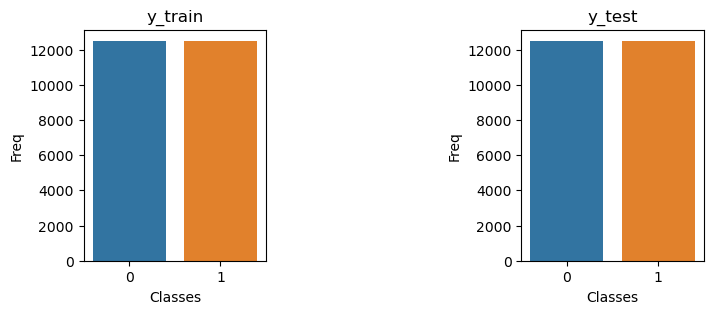

In [171]:
# %load solutions/imdb/positiveProportion.py
plt.figure(figsize = (8,3))

plt.subplot(1,3,1)
sns.countplot(x=y_train)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("y_train")

plt.subplot(1,3,3)
sns.countplot(x=y_test)
plt.xlabel("Classes")
plt.ylabel("Freq")
plt.title("y_test")


unique,  counts = np.unique(y_train, return_counts = True)
print("y_train distribution: ", dict(zip(unique,counts)))

unique,  counts = np.unique(y_test, return_counts = True)
print("y_test distribution: ", dict(zip(unique,counts)))

##### <span style="color:purple">**Question:** How many different words does this database contain?</span>

In [ ]:
### TO BE COMPLETED ### 

vocab_size = ...

print('%d unique words found' % vocab_size)  

In [173]:
# %load solutions/imdb/vocab_size.py
vocab_size = len(imdb.get_word_index())
print('%d unique words found' % vocab_size)  

88584 unique words found


##### <span style="color:purple">**Question:** Are all reviews the same length? If not, what is their maximum length?</span>

This question can be answered using an histogram.

In [ ]:
### TO BE COMPLETED ### 

# Lengths of the reviews

Maximum review length: 2494
Minimum review length: 7


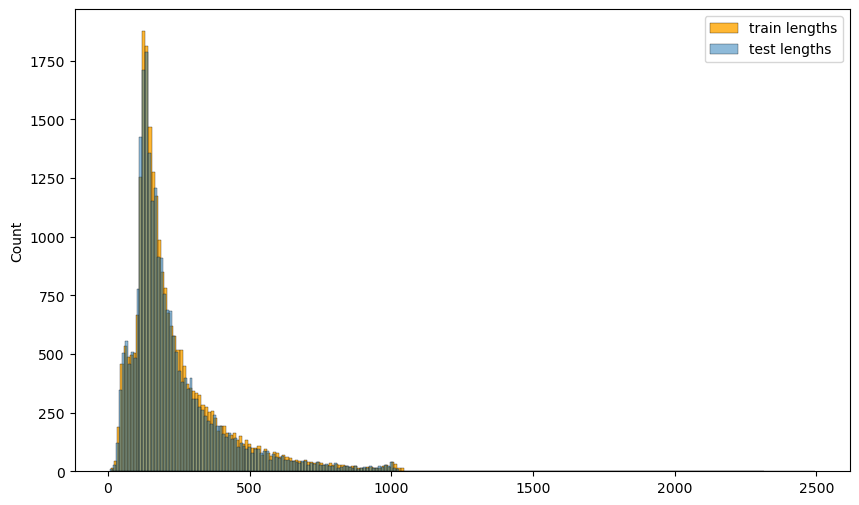

In [175]:
# %load solutions/imdb/reviewsLengths.py
train_lengths = []
for x in X_train:
    train_lengths.append(len(x))
    
test_lengths = []
for x in X_test:
    test_lengths.append(len(x))
    
    
plt.figure(figsize = (10,6))
sns.histplot(x=train_lengths,color='orange',alpha=.8)
sns.histplot(x=test_lengths,alpha=.5)
plt.legend(['train lengths','test lengths'])    


print('Maximum review length: {}'.format(max(train_lengths+test_lengths)))
print('Minimum review length: {}'.format(min(train_lengths+test_lengths)))

### Sequences Padding

The reviews have a variable number of words, while the network has a fixed number of neurons. To get a fixed length input, we can simply truncate the reviews to a fixed number of words, say $\texttt{max_words=200}$. To facilitate learning, we will also limit ourselves to the $\texttt{vocab_size=10000}$ most frequent words.

In [176]:
from tensorflow.keras.preprocessing import sequence

In [177]:
max_words = 200
vocab_size = 10000

(X_train, y_train), (X_test, y_test) = imdb.load_data(start_char=1, oov_char=2, index_from=3, num_words = vocab_size)

X_train_pad = sequence.pad_sequences(X_train, value=0, padding='post', maxlen=max_words)
X_test_pad = sequence.pad_sequences(X_test, value=0, padding='post', maxlen=max_words)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

##### <span style="color:purple">**Todo:** Check that the size of the reviews is now equal to $\texttt{max_words}$ for each of them.</span>

In [ ]:
### TO BE COMPLETED ### 

# Lengths of the reviews

In [179]:
# %load solutions/imdb/paddingLengths.py
lengths = []
for x in X_train_pad+X_test_pad:
    lengths.append(len(x))
    
print('Maximum review length: {}'.format(max(lengths)))
print('Minimum review length: {}'.format(min(lengths)))

Maximum review length: 200
Minimum review length: 200


Let us see the effect of padding and truncation at the most frequent words on the previously displayed idx-th review.

In [180]:
decodeReview(idx)

---review number---
14932

---review in words---
[START] [OOV] [OOV] will never forget this name in his life this is the movie which caused his downfall it was released with much hype but crashed badly and laid to severe financial [OOV] for its producers and [OOV] [OOV] had to personally [OOV] them for the [OOV] [OOV] soon after its release he tried [OOV] into politics but failed miserably its a very bad movie with horrible acting bad quality makeup and pathetic screenplay throughout the movie [OOV] looks like a person suffering from some disease i'm one of the unfortunate souls who saw [OOV] first day first show in theatre the audiences were so bored that most of them left the theatre before the [OOV] sorry i'll not recommend this one to anyone

---label---
0


## RNN for Sentiment Analysis

In [185]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, SimpleRNN, LSTM, Dense, Dropout, Bidirectional

##### <span style="color:purple">**Todo:** Design a RNN model for sentiment analysis.</span>

The first layer must be an [`Embedding`](https://keras.io/api/layers/core_layers/embedding/) layer. To prevent gradient vanishing, choose a suitable recurrent network.

In [182]:
### TO BE COMPLETED ### 
embedding_size = 32

rnn = Sequential(name="RNN")
rnn.add(Embedding(vocab_size, embedding_size, input_length=max_words))
[...]

print(rnn.summary())

Model: "RNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           320000    
Total params: 320,000
Trainable params: 320,000
Non-trainable params: 0
_________________________________________________________________
None


2022-12-06 11:19:50.507261: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-06 11:19:50.510274: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 11:19:50.513657: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [186]:
# %load solutions/imdb/rnn.py
embedding_size = 32

rnn = Sequential(name="RNN")
rnn.add(Embedding(vocab_size, embedding_size, input_length=max_words))
rnn.add(LSTM(int(.5*embedding_size)))
rnn.add(Dropout(0.1))
rnn.add(Dense(1, activation='sigmoid'))

print(rnn.summary())

NotImplementedError: Cannot convert a symbolic Tensor (lstm_1/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

##### <span style="color:purple">**Todo:** Performing the learning.</span>

In [ ]:
### TO BE COMPLETED ### 

batch_size = 100
num_epochs = 8

X_valid, y_valid = X_train_pad[:batch_size], y_train_pad[:batch_size]
X_train_rnn, y_train_rnn = X_train_pad[batch_size:], y_train_pad[batch_size:]


rnn.compile(loss=..., 
             optimizer=..., 
             metrics=['accuracy'])

history_rnn = rnn.fit(...)

In [188]:
# %load solutions/imdb/rnnTraining.py
batch_size = 100
num_epochs = 8

X_valid, y_valid = X_train_pad[:batch_size], y_train[:batch_size]
X_train_rnn, y_train_rnn = X_train_pad[batch_size:], y_train[batch_size:]


rnn.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

history_rnn = rnn.fit(X_train_rnn, 
                    y_train_rnn, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=batch_size, 
                    epochs=num_epochs)

2022-12-06 11:20:33.660467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-06 11:20:33.732971: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/8


ValueError: in user code:

    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1608 binary_crossentropy
        K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4994 binary_crossentropy
        bce = target * math_ops.log(output + epsilon())
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1180 binary_op_wrapper
        raise e
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1164 binary_op_wrapper
        return func(x, y, name=name)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1496 _mul_dispatch
        return multiply(x, y, name=name)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:518 multiply
        return gen_math_ops.mul(x, y, name)
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:6077 mul
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:748 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/framework/func_graph.py:590 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:3528 _create_op_internal
        ret = Operation(
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:2015 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    /usr/local/insa/anaconda/lib/python3.9/site-packages/tensorflow/python/framework/ops.py:1856 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 100 and 200 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](binary_crossentropy/Cast, binary_crossentropy/Log)' with input shapes: [100,1], [100,200,32].


##### <span style="color:purple">**Todo:** Visualize the learning process.</span>

Write a function that allows to represent on two different figures the accuracy on one hand, and the loss on the other hand, each for the training and test data.

In [ ]:
### TO BE COMPLETED ### 

def plotTraining(history):
    [...]

In [ ]:
# %load solutions/imdb/plotTraining.py

In [ ]:
plotTraining(history_rnn)

## Bidirectional RNN

As defined, this network introduces a causal structure into the data. Also, for text processing, we often prefer a bidirectional network. To do this, we can use the [`Bidirectional`](https://keras.io/api/layers/recurrent_layers/bidirectional/) command.

In [ ]:
embedding_size = 32

bi_rnn = Sequential(name="Bidirectional_RNN")
bi_rnn.add(Embedding(vocab_size, embedding_size, input_length=max_words))
bi_rnn.add(Bidirectional(LSTM(int(.5*embedding_size))))  ### NEW ###
bi_rnn.add(Dropout(0.1))
bi_rnn.add(Dense(1, activation='sigmoid'))

print(bi_rnn.summary())

In [ ]:
batch_size = 100
num_epochs = 8

X_valid, y_valid = X_train_pad[:batch_size], y_train[:batch_size]
X_train_rnn, y_train_rnn = X_train_pad[batch_size:], y_train[batch_size:]


bi_rnn.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

history_bi_rnn = bi_rnn.fit(X_train_rnn, 
                    y_train_rnn, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=batch_size, 
                    epochs=num_epochs)

plotTraining(history_bi_rnn)

Thanks to the $\texttt{return_sequences}$ option, we can easily stack several RNN.

In [ ]:
embedding_size = 32

bi2_rnn = Sequential(name="Double_Bidirectional_RNN")
bi2_rnn.add(Embedding(vocab_size, embedding_size, input_length=max_words))
bi2_rnn.add(Bidirectional(LSTM(int(.5*embedding_size), return_sequences = True)))
bi2_rnn.add(Bidirectional(LSTM(int(.5*embedding_size), return_sequences = False)))
bi2_rnn.add(Dropout(0.1))
bi2_rnn.add(Dense(1, activation='sigmoid'))

print(bi2_rnn.summary())

In [ ]:
batch_size = 100
num_epochs = 8

X_valid, y_valid = X_train_pad[:batch_size], y_train[:batch_size]
X_train_rnn, y_train_rnn = X_train_pad[batch_size:], y_train[batch_size:]


bi2_rnn.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

history_bi2_rnn = bi2_rnn.fit(X_train_rnn, 
                    y_train_rnn, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=batch_size, 
                    epochs=num_epochs)

plotTraining(history_bi2_rnn)

## Confusion Matrices

In [ ]:
from sklearn.metrics import confusion_matrix

##### <span style="color:purple">**Todo:** Compare the confusion matrices for the three models proposed above.</span>

In [ ]:
### TO BE COMPLETED ### 

# Compare the confusion matrices

In [ ]:
# %load solutions/imdb/confusion.py

## MLP for Sentiment Analysis

Just to be sure of the usefulness of a recurrent network, we decide to test a "simple" perceptron on the IMDB dataset.

##### <span style="color:purple">**Todo:** Compare the above results with those of an MLP. Conclude.</span>

In [ ]:
### TO BE COMPLETED ### 

# Comparison with a MLP

In [ ]:
# %load solutions/imdb/mlp.py